In [43]:
%pylab inline
import scipy.stats
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Model Definition

In [107]:
# parameters specifying the probability model: 
#  boundaries of the world, 
#  locations of stations,
#  event rate,
#  arrival time distribution,
#  and signal properties


# "hard" setting: larger world
event_rate = 0.02
start_time = 0.0
end_time = 200.0
timespan = end_time-start_time

xmin = 0.0
xmax = 100.0
station_locs = [0.0, 33.0, 66.0, 100.0]
n_stations = len(station_locs)

wave_velocity = 1.0
MAX_TRAVEL_TIME = int((xmax-xmin)/wave_velocity)
arrival_time_stddev = 3.0

station_noise_stddev = [1.0, 1.0, 1.0, 1.0, 1.0]
event_signal_stddev = 4.0
signal_duration = 10.0

In [108]:
# Code to sample a world from the model (i.e., from the prior distribution on worlds).


def station_stddev(i, events):
    # helper function to compute signal probabilities. 
    # given:
    #  i: station index
    #  events: matrix representing an event hypothesis (see generate_from_prior)
    # return 
    #  s: vector of the same length as the signal at s, giving the stddev of the
    #     signal at each timestep.
    s = np.ones(int(timespan+MAX_TRAVEL_TIME)) * station_noise_stddev[i]**2

    for ev in events:
        station_arrival_time = ev[i+2]
        arrival_start_idx = max(start_time, int(station_arrival_time))
        arrival_end_idx = min(end_time+MAX_TRAVEL_TIME, int(station_arrival_time + signal_duration))
        if arrival_start_idx > (end_time+MAX_TRAVEL_TIME) or arrival_end_idx < start_time or arrival_end_idx <= arrival_start_idx: 
            continue
        arrival_len = arrival_end_idx - arrival_start_idx

        s[arrival_start_idx:arrival_end_idx] += event_signal_stddev**2         
    return np.sqrt(s)

def sample_event_from_prior():
    # sample from the prior distribution on an event's time, location, and arrival times at all stations
    t_origin = float(scipy.stats.uniform(start_time, scale=timespan).rvs(1))
    x_origin = float(scipy.stats.uniform(xmin, scale=(xmax-xmin)).rvs(1))
    event_state = [t_origin, x_origin]

    # and sample the arrival time at each station
    for x_station in station_locs:
        arrival_time_mean = t_origin + np.abs(x_station-x_origin)/wave_velocity
        arrival_time = float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).rvs(1))
        event_state.append(arrival_time)
    return event_state

def sample_world_from_prior():
    
    # sample the number of events from a Poisson prior
    n_events = scipy.stats.poisson(event_rate * timespan).rvs(1)
    
    # for each event, sample an origin time and location uniformly at random
    sampled_events = []
    for i in range(n_events):
        event_state = sample_event_from_prior()
        sampled_events.append(event_state)

    # represent event state as a matrix:
    #  - each row is a different event
    #  - columns 0 and 1 are origin time and location
    #  - for i >= 0, column i+2 is the arrival time at station i
    sampled_events = np.asarray(sampled_events)
    
    # sample the signals generated at each station
    signals = []
    for i in range(n_stations):
        # sample background noise at each station
        s = station_stddev(i, sampled_events)
        signal = np.random.randn(len(s)) * s
        signals.append(signal)
    
    return sampled_events, signals

In [109]:
# Code to compute probabilities of worlds under the model

def arrival_time_logp(event):
    # helper function to compute the log probability of an event's arrival times,
    # given the origin location.
    atime_lp = 0
    t_origin, x_origin = event[0], event[1]
    for i, x_station in enumerate(station_locs):            
        arrival_time_mean = t_origin + np.abs(x_station-x_origin)/wave_velocity
        arrival_time_observed = event[i+2]
        atime_lp += float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).logpdf(arrival_time_observed))
    return atime_lp

# compute the (log) probability density of a possible world
def logp(events, signals, temper=1.0):

    # events out of bounds have zero probability under the model
    n_events = events.shape[0]
    if n_events > 0 and ((events[:, 0] < start_time).any() or (events[:, 0] > end_time).any()):
        return -np.inf
    if n_events > 0 and ((events[:, 1] < xmin).any() or (events[:, 1] > xmax).any()):
        return -np.inf
    
    # log probability of n events, with uniform arrival times, under
    # a Poisson process.
    # equal to log( Poisson(n_events; event_rate) * (1/timespan)**(n_events) * factorial(n_events) )
    # where the factorial comes from summing over the number of events. 
    ev_prior_lp = n_events * np.log(event_rate) - (event_rate * timespan)
    
    # probability of event locations under a uniform prior
    ev_prior_lp += n_events - np.log((xmax-xmin))

    # probability of arrival times under the arrival-time model
    atime_lp = 0
    for event in events:
        atime_lp += arrival_time_logp(event)
        
            
    # probability of signals, given the hypothesized arrival times
    signal_lp = 0
    for i in range(n_stations):
        s = station_stddev(i, events)
        # probability of the signal under an iid Gaussian model.
        # equiv to 
        # signal_lp += np.sum([scipy.stats.norm(scale=s[j]).logpdf(signals[i][j]) for j in range(len(s))])
        # but to save computation we write out the Gaussian density explicitly
        scaled_signal = signals[i]/s
        gaussian_lp = -.5*np.dot(scaled_signal, scaled_signal)
        gaussian_lp += -np.sum(np.log(s)) - .5*len(s)*np.log(2*np.pi)
        signal_lp += gaussian_lp
        
    lp = ev_prior_lp + atime_lp + signal_lp
    return lp

# Visualization

In [110]:

def visualize_samples(samples=None, true_events=None):
    width = 5
    height = width * (timespan / (xmax-xmin))
    f = figure(figsize=(width, height))
    ax = f.add_subplot(111)
    
    if true_events is not None:
        ax.scatter(true_events[:, 1], true_events[:, 0], alpha=1.0, s=40, marker="*", color="red")
    
    if samples is not None:
        n_samples = len(samples)
        for events in samples:
            if events.shape[0] == 0: continue
            ax.scatter(events[:, 1], events[:, 0], alpha=1.0/np.sqrt(n_samples), s=2)

    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((start_time, end_time))
    
    for x_station in station_locs:
        ax.axvline(x_station, c='green')


def visualize_signals(events, signals):
    for i in range(n_stations):
        s = station_stddev(i, events)
        f = figure(figsize(20, 5))
        ax = f.add_subplot(121)
        ax.plot(signals[i])
        ax.plot(s, c="red")
        ax.set_title("signal at station %d, x=%.1f" % (i, station_locs[i]))




sampled 4 events
[[  94.65885404   25.52977487  118.42756814  104.88460059  137.14260575
   171.66040152]
 [ 197.3973369    43.52909762  234.6683336   205.1465637   224.36967735
   250.76785935]
 [  96.21859213   91.09742624  193.05419199  158.03097782  124.35953685
   106.01201223]
 [ 101.19376698   60.87140433  164.76598665  124.28588874  106.82752902
   139.00899208]]
log density -1932.60332958


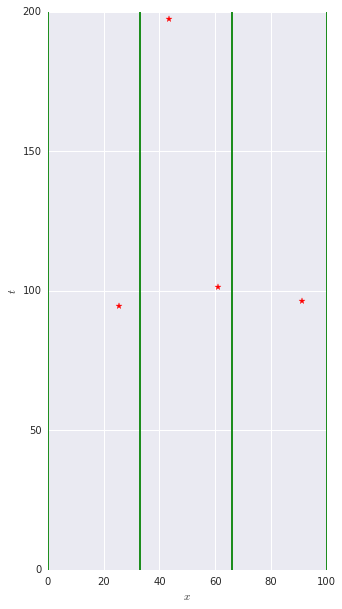

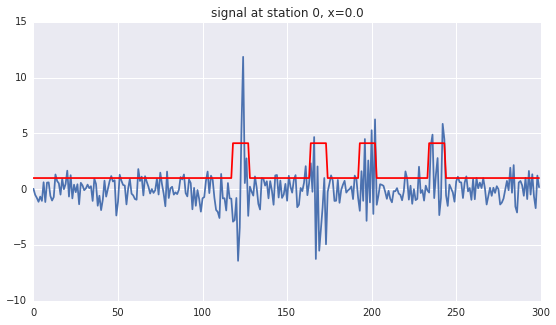

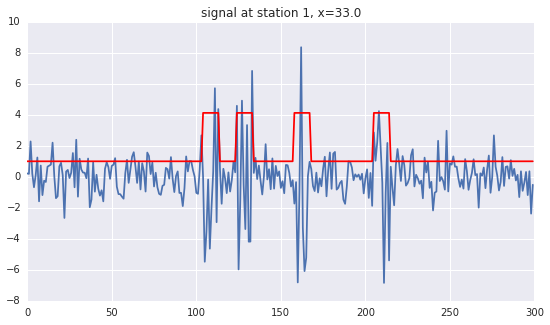

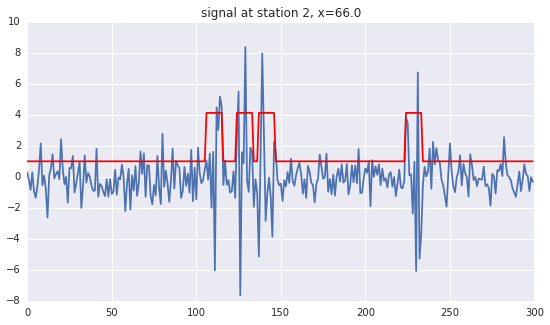

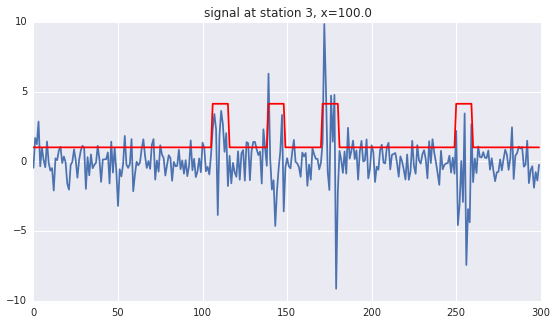

In [111]:
# sample a world from the model, 
# compute its log probability density,
# and visualize the events and the generated signals

sampled_events, signals = sample_world_from_prior()
print "sampled %d events" % len(sampled_events)
print sampled_events
print "log density", logp(sampled_events, signals)
visualize_samples(samples=None, true_events=sampled_events)
visualize_signals(sampled_events, signals)

# Inference (Metropolis-Hastings)

In [117]:
def event_loc_move(events, proposal_stddev = 4.0):
    # MH proposal: move a random event by a Gaussian offset in space and time
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0
    
    event_idx = np.random.choice(np.arange(n_events))
    proposed_events = events.copy()
    proposed_events[event_idx, :2] += np.random.randn(2) * proposal_stddev

    return proposed_events, 0.0, 0.0

def atime_move(events, proposal_stddev = 4.0):
    # MH proposal: change the arrival time of a random event at a random station by a Gaussian
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0
    
    event_idx = np.random.choice(np.arange(n_events))
    sta_idx = np.random.choice(np.arange(n_stations))
    proposed_events = events.copy()
    proposed_events[event_idx, sta_idx + 2] += np.random.randn(1) * proposal_stddev
    return proposed_events, 0.0, 0.0

def birthdeath_move(events):
    # MH proposal: birth a new event or kill an existing event
    n_events = events.shape[0]

    # attempt with equal probability to birth a new event or kill an existing event
    birth = np.random.rand() < .5
    
    if birth:
        proposed_event= np.asarray(sample_event_from_prior())
        # log probability of proposing this time and location
        log_q_forward = -np.log(timespan) - np.log((xmax-xmin))
        
        # plus the arrival times
        log_q_forward += arrival_time_logp(proposed_event)
        
        # reverse probability that we'd propose to kill this event
        log_q_backward = -np.log(n_events+1)
        
        if n_events == 0:
            proposed_events = proposed_event.reshape((1, -1))
        else:
            proposed_events = np.vstack((events, proposed_event.reshape((1, -1))))
        
    else:
        if n_events == 0:
            return events, 0.0, 0.0
        
        # choose an event to kill
        event_idx = np.random.choice(np.arange(n_events))
        dead_event = events[event_idx, :]
        
        # probability of killing this particular event is uniform on the number of events
        log_q_forward = -np.log(n_events)

        # reverse probability that we'd birth this event
        log_q_backward = -np.log(timespan) - np.log((xmax-xmin))
        log_q_backward += arrival_time_logp(dead_event)
        
        proposed_events = np.vstack((events[:event_idx, :], events[event_idx+1:, :]))

    return proposed_events, log_q_forward, log_q_backward
        
def run_mh(x0, signals, steps):
    
    moves = [event_loc_move, atime_move, birthdeath_move]
    move_probs = [0.48, 0.48, 0.04]
    move_names = ["event_loc", "atime", "birthdeath"]
    attempts = [0 for move in moves]
    successes = [0 for move in moves]
    
    x = x0
    lp = logp(x, signals)
    
    samples = [x,]
    lps = [lp,]
    for i in range(steps):
        move_idx = np.random.choice(np.arange(len(moves)), p=move_probs)
        move = moves[move_idx]
        proposed_x, log_q_forward, log_q_backward = move(x)
        proposed_lp = logp(proposed_x, signals)
        log_accept_ratio = (proposed_lp + log_q_backward) - (lp + log_q_forward)
        u = np.log(np.random.rand())
        if log_accept_ratio > u:
            x = proposed_x
            lp = proposed_lp
            successes[move_idx] += 1
        attempts[move_idx] += 1
        samples.append(x)
        lps.append(lp)

        if i % 200 == 0:
            print "step %d, lp %.1f, %d events, acceptance rates" % (i, lp, x.shape[0]),
            for j in arange(len(moves)):
                print " %s %.3f" % (move_names[j], float(successes[j])/attempts[j] if attempts[j] > 0 else -1),
            print 
            
    return samples, lps

# initialize at the empty world
x0 = np.zeros((0, 0)) 

# intialize by overproposing events
# x0 = np.array([sample_event_from_prior() for i in range(40)])

# initialize at the truth
# (cheating, but should give a better picture of the true posterior)
# x0 = sampled_events 

mh_samples, mh_lps = run_mh(x0, signals, steps=50000)

step 0, lp -2787.4, 0 events, acceptance rates  event_loc 1.000  atime -1.000  birthdeath -1.000
step 200, lp -2787.4, 0 events, acceptance rates  event_loc 1.000  atime 1.000  birthdeath 0.636
step 400, lp -2550.3, 2 events, acceptance rates  event_loc 0.793  atime 0.824  birthdeath 0.647
step 600, lp -2471.2, 5 events, acceptance rates  event_loc 0.598  atime 0.658  birthdeath 0.500
step 800, lp -2295.4, 6 events, acceptance rates  event_loc 0.505  atime 0.621  birthdeath 0.417
step 1000, lp -2253.1, 6 events, acceptance rates  event_loc 0.460  atime 0.558  birthdeath 0.385
step 1200, lp -2238.1, 6 events, acceptance rates  event_loc 0.419  atime 0.518  birthdeath 0.319
step 1400, lp -2242.4, 7 events, acceptance rates  event_loc 0.399  atime 0.484  birthdeath 0.267
step 1600, lp -2199.4, 5 events, acceptance rates  event_loc 0.376  atime 0.453  birthdeath 0.257
step 1800, lp -2042.0, 6 events, acceptance rates  event_loc 0.365  atime 0.436  birthdeath 0.259
step 2000, lp -2028.5, 6 

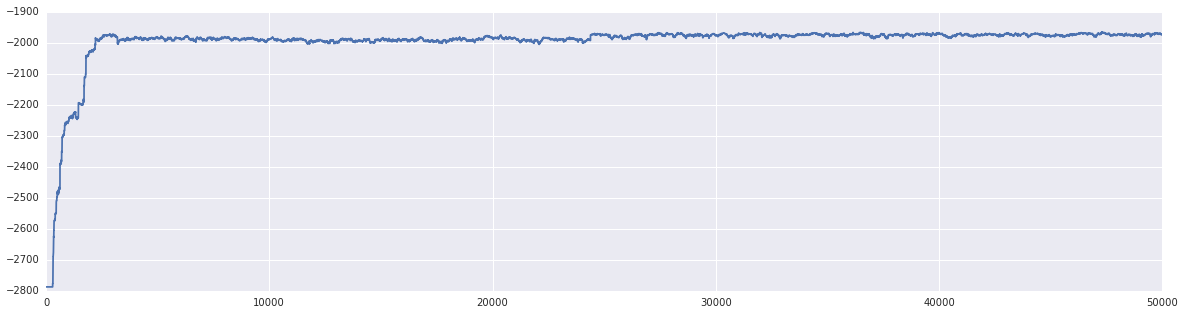

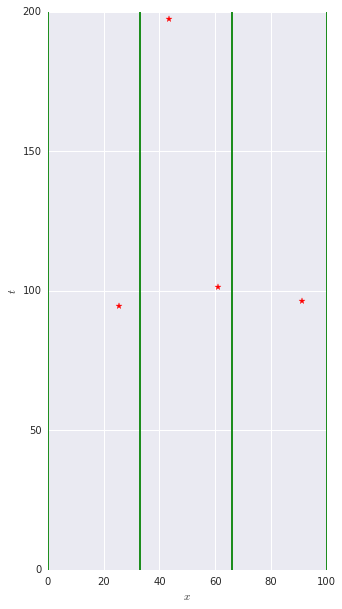

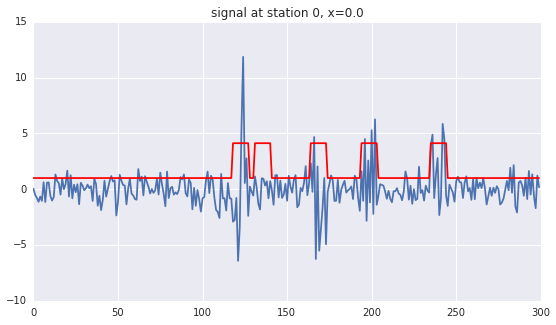

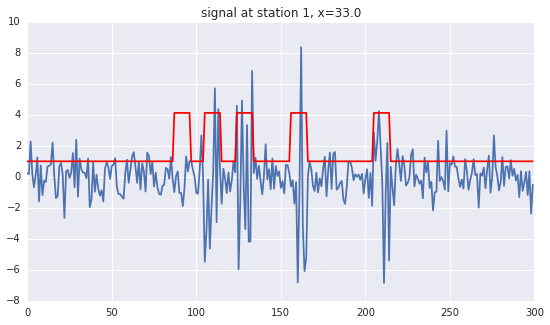

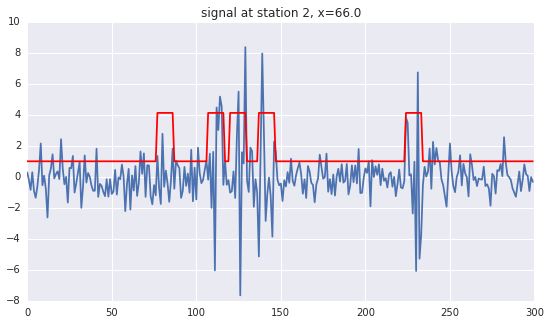

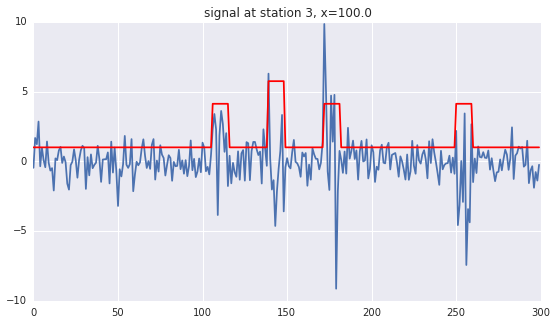

In [118]:
# WARNING: densities are not comparable between worlds with different numbers of events!
plot(mh_lps)

visualize_samples(mh_samples, sampled_events)
visualize_signals(mh_samples[-1], signals)